<a href="https://colab.research.google.com/github/AstraBert/DebateLLM-Championship/blob/main/DebateLLMChampionship_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install necessary dependencies

In [1]:
! pip install --quiet datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [14]:
! pip install --quiet rake_nltk

In [19]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 2. Import necessary data

In [3]:
from datasets import load_dataset

dataset = load_dataset("as-cle-bert/DebateLLMs")
df = dataset["train"]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

debatellms.csv:   0%|          | 0.00/68.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20 [00:00<?, ? examples/s]

In [4]:
import pandas as pd

df = pd.DataFrame(df)

# 3. Analyse most frequent words in various settings

## 3a. Winners where QwQ is a judge

In [22]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import numpy as np

df_qwq = df[df["judge"] == "Qwen/QwQ-32B-Preview"]

def compare_winning_arg_w_motion(df: pd.DataFrame) -> Dict:
    """
    Analyzes the relationship between winning arguments and their motions.
    Returns a dictionary containing analysis results and statistics.
    """
    # Initialize containers for analysis
    keyword_overlap_scores = []
    winning_word_frequencies = Counter()
    motion_word_frequencies = Counter()
    favor_win_count = 0
    against_win_count = 0
    overlap_by_length = []

    # Analysis results
    results = {
        'overlap_scores': [],
        'word_frequencies': {},
        'winning_sides': {},
        'length_correlations': []
    }

    for index, row in df.iterrows():
        motion = row["motions"]
        motion_keywords = set(extract_keywords(motion))
        motion_word_frequencies.update(motion_keywords)

        # Determine winning argument
        is_favor_winning = row["winner"] == row["favor_model"]
        winning_arg = row["favor_arg"] if is_favor_winning else row["against_arg"]

        # Update win counters
        if is_favor_winning:
            favor_win_count += 1
        else:
            against_win_count += 1

        # Extract and analyze winning argument
        common_words = set(extract_most_common_words(winning_arg, len(motion_keywords)))
        winning_word_frequencies.update(common_words)

        # Calculate overlap score
        overlap = len(motion_keywords.intersection(common_words)) / len(motion_keywords)
        keyword_overlap_scores.append(overlap)

        # Record length correlation
        overlap_by_length.append((len(winning_arg.split()), overlap))

    # Store results
    results['overlap_scores'] = keyword_overlap_scores
    results['word_frequencies'] = {
        'motion': dict(motion_word_frequencies.most_common(20)),
        'winning_args': dict(winning_word_frequencies.most_common(20))
    }
    results['winning_sides'] = {
        'favor': favor_win_count,
        'against': against_win_count
    }
    results['length_correlations'] = overlap_by_length

    # Create visualizations
    create_analysis_plots(results)

    return results

def create_analysis_plots(results: Dict):
    """Creates and displays analysis visualizations."""
    # Set up the plotting area
    plt.style.use('seaborn-v0_8-paper')
    fig = plt.figure(figsize=(15, 10))

    # 1. Overlap Score Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(results['overlap_scores'], bins=20)
    plt.title('Distribution of Keyword Overlap Scores')
    plt.xlabel('Overlap Score')
    plt.ylabel('Count')

    # 2. Winning Sides Pie Chart
    plt.subplot(2, 2, 2)
    sides = results['winning_sides']
    plt.pie([sides['favor'], sides['against']],
            labels=['Favor', 'Against'],
            autopct='%1.1f%%')
    plt.title('Distribution of Winning Sides')

    # 3. Word Frequencies Comparison
    plt.subplot(2, 2, 3)
    motion_words = list(results['word_frequencies']['motion'].keys())[:10]
    motion_freqs = [results['word_frequencies']['motion'][w] for w in motion_words]
    plt.barh(motion_words, motion_freqs)
    plt.title('Top 10 Motion Keywords')
    plt.xlabel('Frequency')

    # 4. Length vs Overlap Scatter Plot
    plt.subplot(2, 2, 4)
    lengths, overlaps = zip(*results['length_correlations'])
    plt.scatter(lengths, overlaps, alpha=0.5)
    plt.title('Argument Length vs Keyword Overlap')
    plt.xlabel('Argument Length (words)')
    plt.ylabel('Overlap Score')

    # Add trend line
    z = np.polyfit(lengths, overlaps, 1)
    p = np.poly1d(z)
    plt.plot(lengths, p(lengths), "r--", alpha=0.8)

    plt.tight_layout()
    plt.show()

# Helper functions (assuming these exist)
def extract_keywords(text: str) -> List[str]:
    """Extract keywords from text. Implement your keyword extraction logic here."""
    # Example implementation (you might want to customize this)
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text.lower())
    return [w for w in words if w.isalnum() and w not in stop_words]

def extract_most_common_words(text: str, n: int) -> List[str]:
    """Extract n most common words from text."""
    # Example implementation (you might want to customize this)
    words = extract_keywords(text)
    return [word for word, _ in Counter(words).most_common(n)]

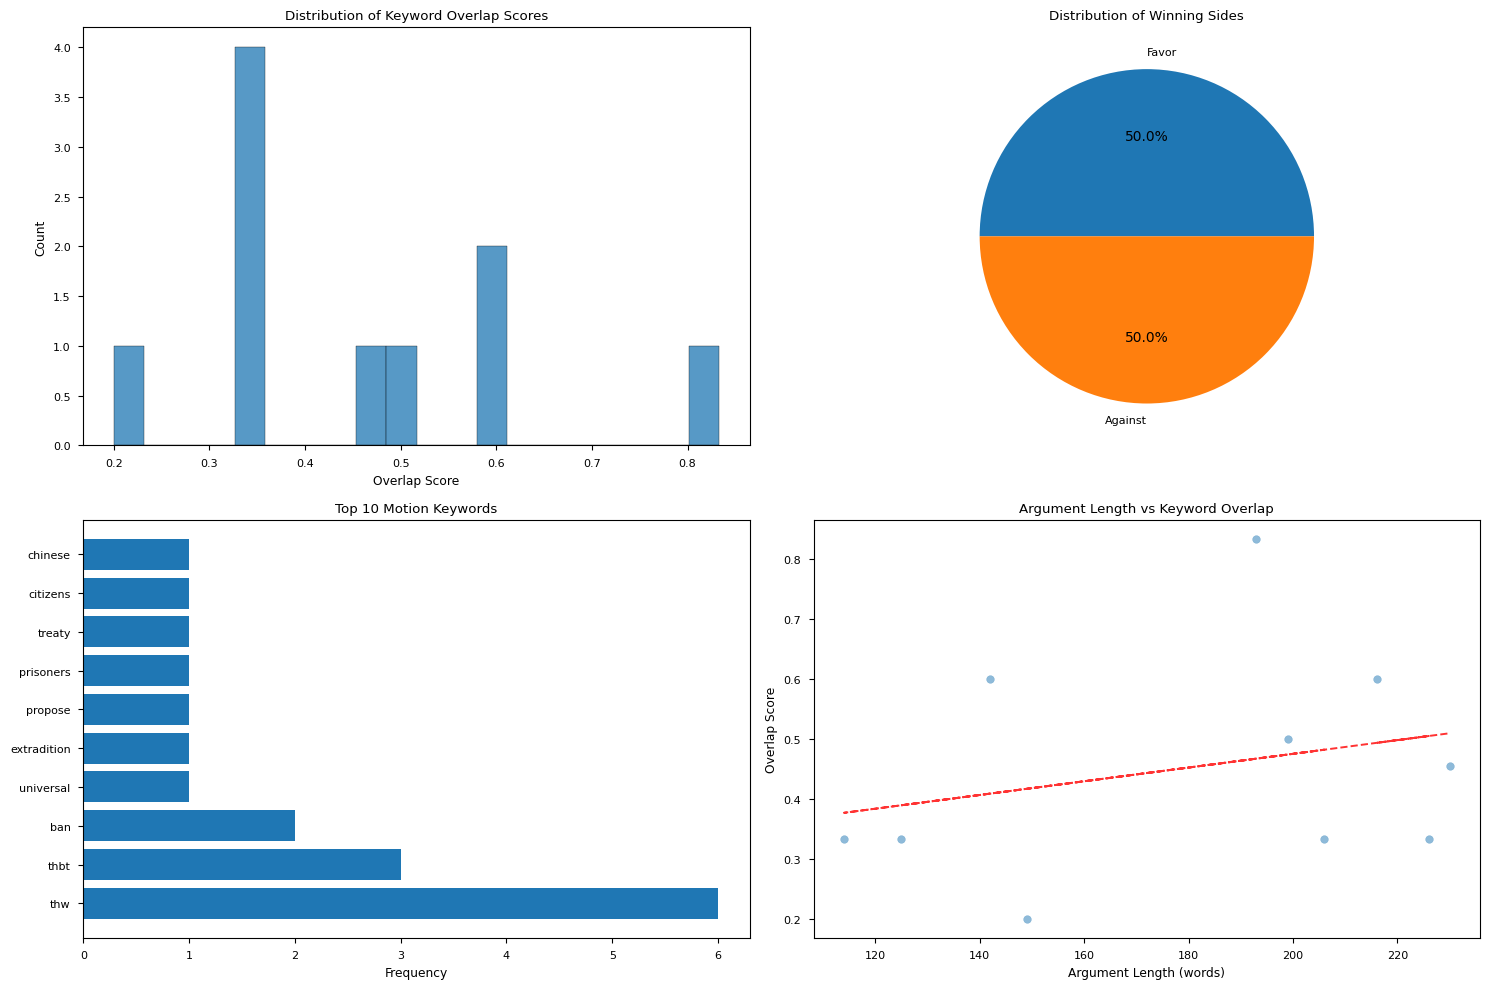

{'overlap_scores': [0.3333333333333333,
  0.6,
  0.2,
  0.8333333333333334,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.3333333333333333,
  0.6,
  0.45454545454545453],
 'word_frequencies': {'motion': {'thw': 6,
   'thbt': 3,
   'ban': 2,
   'universal': 1,
   'extradition': 1,
   'propose': 1,
   'prisoners': 1,
   'treaty': 1,
   'citizens': 1,
   'chinese': 1,
   'censorship': 1,
   'opposes': 1,
   'th': 1,
   'nations': 1,
   'democratization': 1,
   'united': 1,
   'promote': 1,
   'social': 1,
   'movements': 1,
   'buddhist': 1},
  'winning_args': {'human': 2,
   'could': 2,
   'standards': 1,
   'extradition': 1,
   'rights': 1,
   'legal': 1,
   'treaty': 1,
   'citizens': 1,
   'chinese': 1,
   'censorship': 1,
   'government': 1,
   'un': 1,
   'nations': 1,
   'would': 1,
   'representative': 1,
   'security': 1,
   'social': 1,
   'movements': 1,
   'buddhist': 1,
   'lead': 1}},
 'winning_sides': {'favor': 5, 'against': 5},
 'length_correlations': [(125, 0.333

In [23]:
compare_winning_arg_w_motion(df_qwq)

## 3b. Winners when Llama is a judge

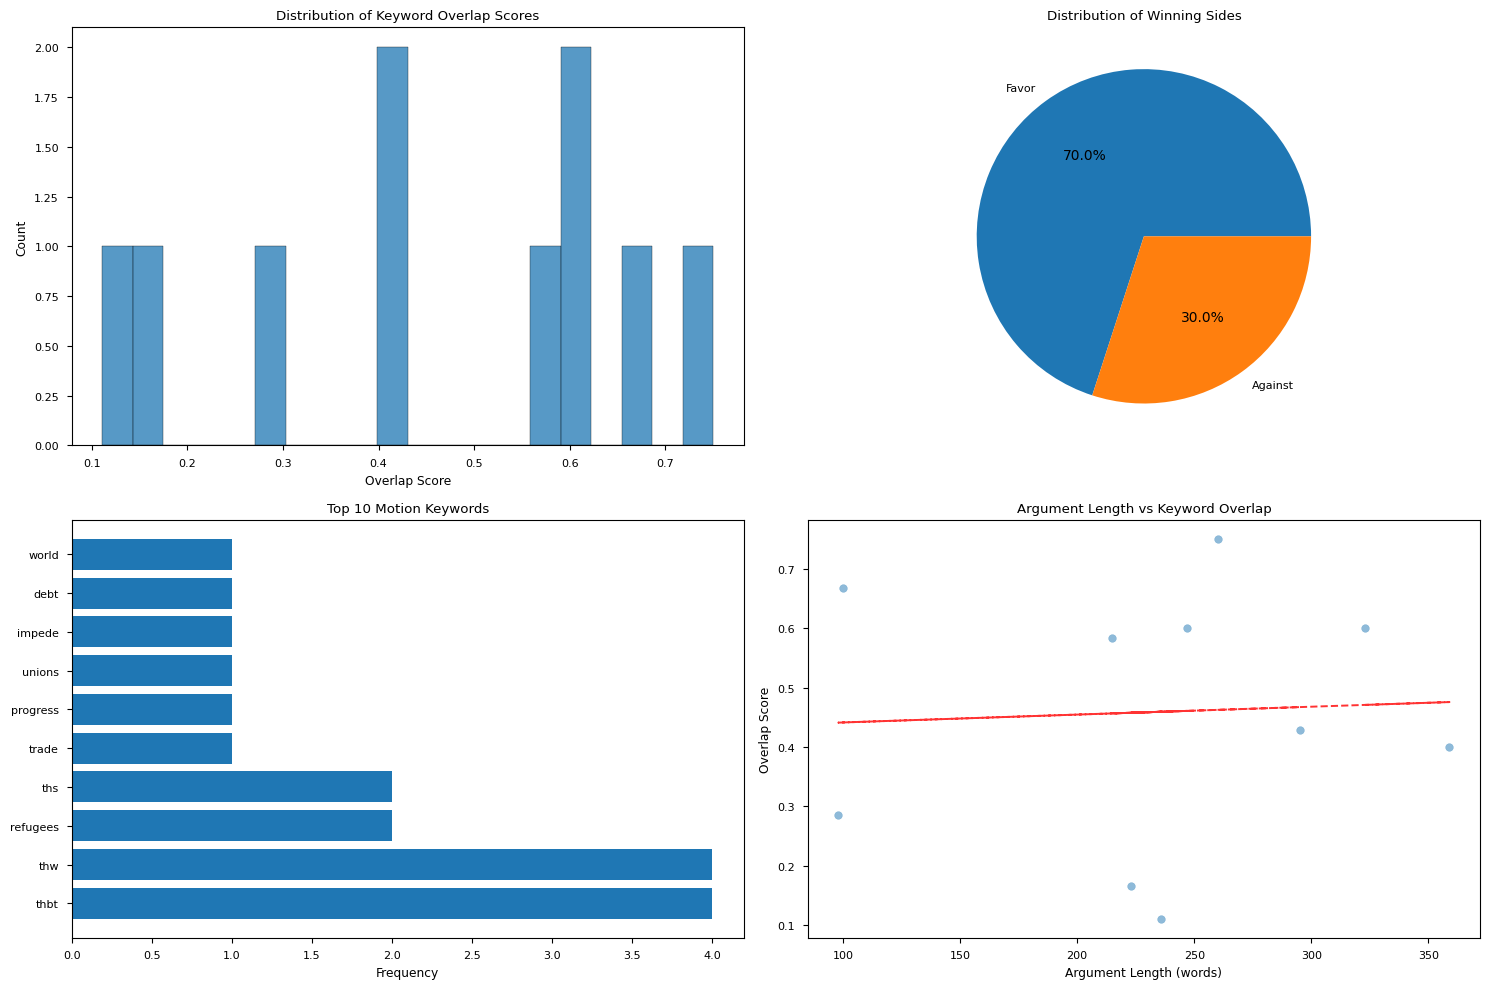

{'overlap_scores': [0.6,
  0.4,
  0.75,
  0.5833333333333334,
  0.6,
  0.2857142857142857,
  0.6666666666666666,
  0.1111111111111111,
  0.16666666666666666,
  0.42857142857142855],
 'word_frequencies': {'motion': {'thbt': 4,
   'thw': 4,
   'refugees': 2,
   'ths': 2,
   'trade': 1,
   'progress': 1,
   'unions': 1,
   'impede': 1,
   'debt': 1,
   'world': 1,
   '3rd': 1,
   'cancel': 1,
   'ill': 1,
   'medical': 1,
   'scarce': 1,
   'patients': 1,
   'resources': 1,
   'deny': 1,
   'terminally': 1,
   'european': 1},
  'winning_args': {'economic': 3,
   'job': 2,
   'countries': 2,
   'refugees': 2,
   'international': 2,
   'unions': 1,
   'trade': 1,
   'progress': 1,
   'reduced': 1,
   'debt': 1,
   'world': 1,
   'third': 1,
   'ill': 1,
   'access': 1,
   'medical': 1,
   'scarce': 1,
   'patients': 1,
   'resources': 1,
   'terminally': 1,
   'care': 1}},
 'winning_sides': {'favor': 7, 'against': 3},
 'length_correlations': [(323, 0.6),
  (359, 0.4),
  (260, 0.75),
  (215,

In [24]:
df_llama = df[df["judge"] == "meta-llama/Llama-3.3-70B-Instruct"]

compare_winning_arg_w_motion(df_llama)

## 3c. Phi-3.5 winning arguments

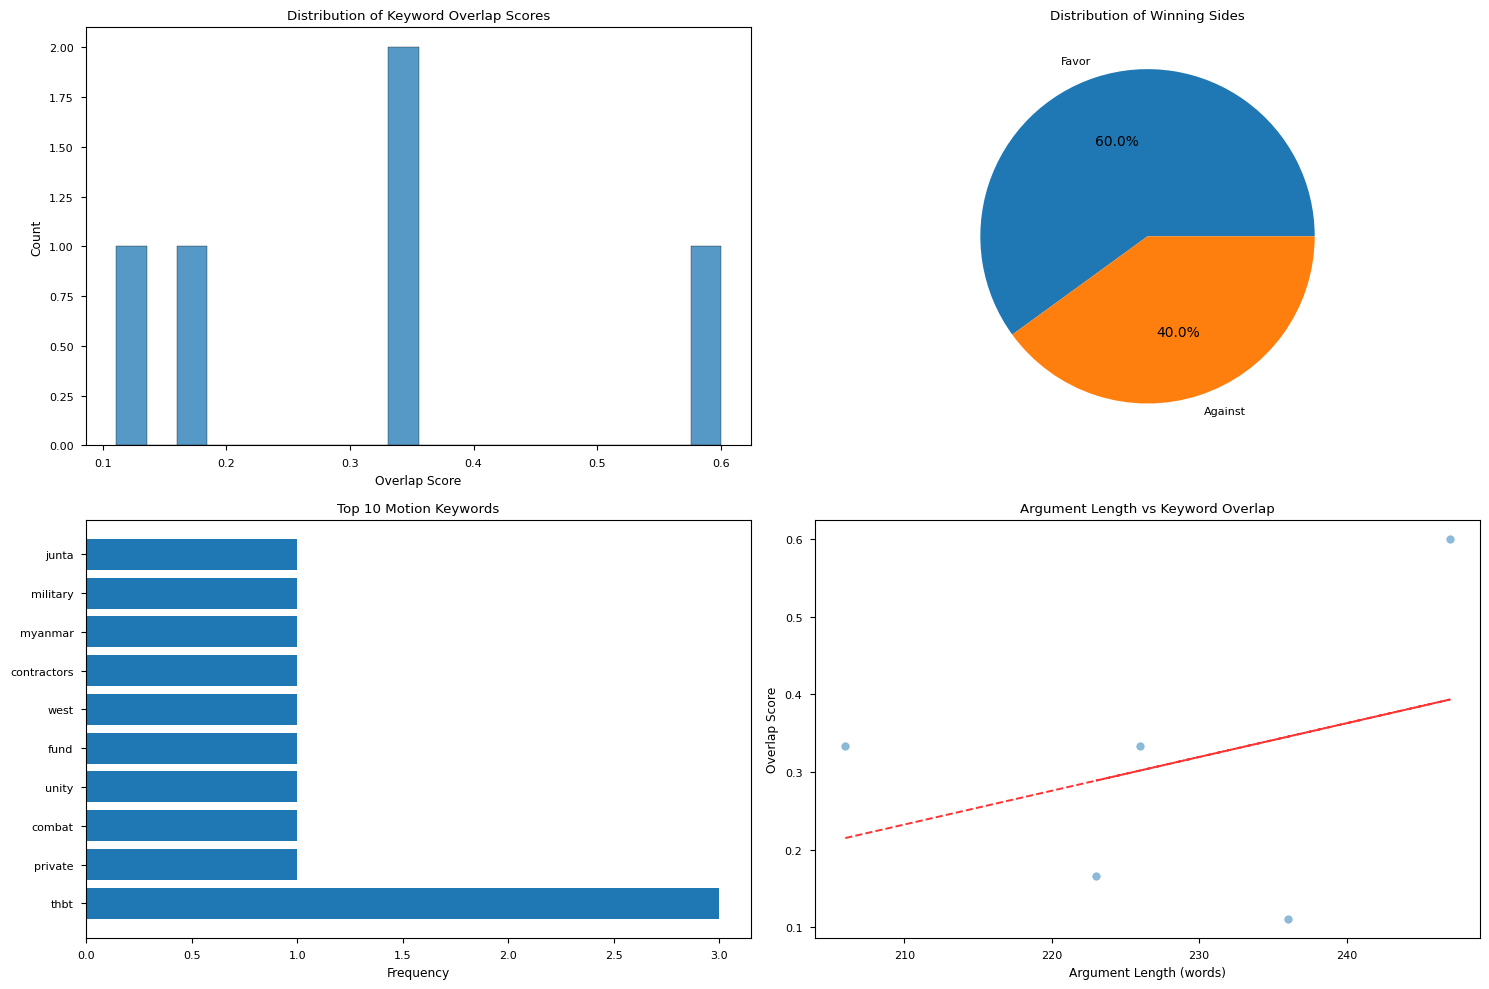

{'overlap_scores': [0.3333333333333333,
  0.3333333333333333,
  0.6,
  0.1111111111111111,
  0.16666666666666666],
 'word_frequencies': {'motion': {'thbt': 3,
   'private': 1,
   'combat': 1,
   'unity': 1,
   'fund': 1,
   'west': 1,
   'contractors': 1,
   'myanmar': 1,
   'military': 1,
   'junta': 1,
   'national': 1,
   'government': 1,
   'thw': 1,
   'ban': 1,
   'websites': 1,
   'refugees': 1,
   'korean': 1,
   'north': 1,
   'repatriation': 1,
   'ths': 1},
  'winning_args': {'involvement': 1,
   'pmcs': 1,
   'west': 1,
   'contractors': 1,
   'nug': 1,
   'could': 1,
   'military': 1,
   'funding': 1,
   'diplomatic': 1,
   'myanmar': 1,
   'leading': 1,
   'conflict': 1,
   'health': 1,
   'medical': 1,
   'websites': 1,
   'refugees': 1,
   'international': 1,
   'rights': 1,
   'north': 1,
   'repatriation': 1}},
 'winning_sides': {'favor': 3, 'against': 2},
 'length_correlations': [(206, 0.3333333333333333),
  (226, 0.3333333333333333),
  (247, 0.6),
  (236, 0.11111111

In [25]:
df_phi = df[df["winner"] == "microsoft/Phi-3.5-mini-instruct"]
compare_winning_arg_w_motion(df_phi)

## 3d. StarChat losing arguments

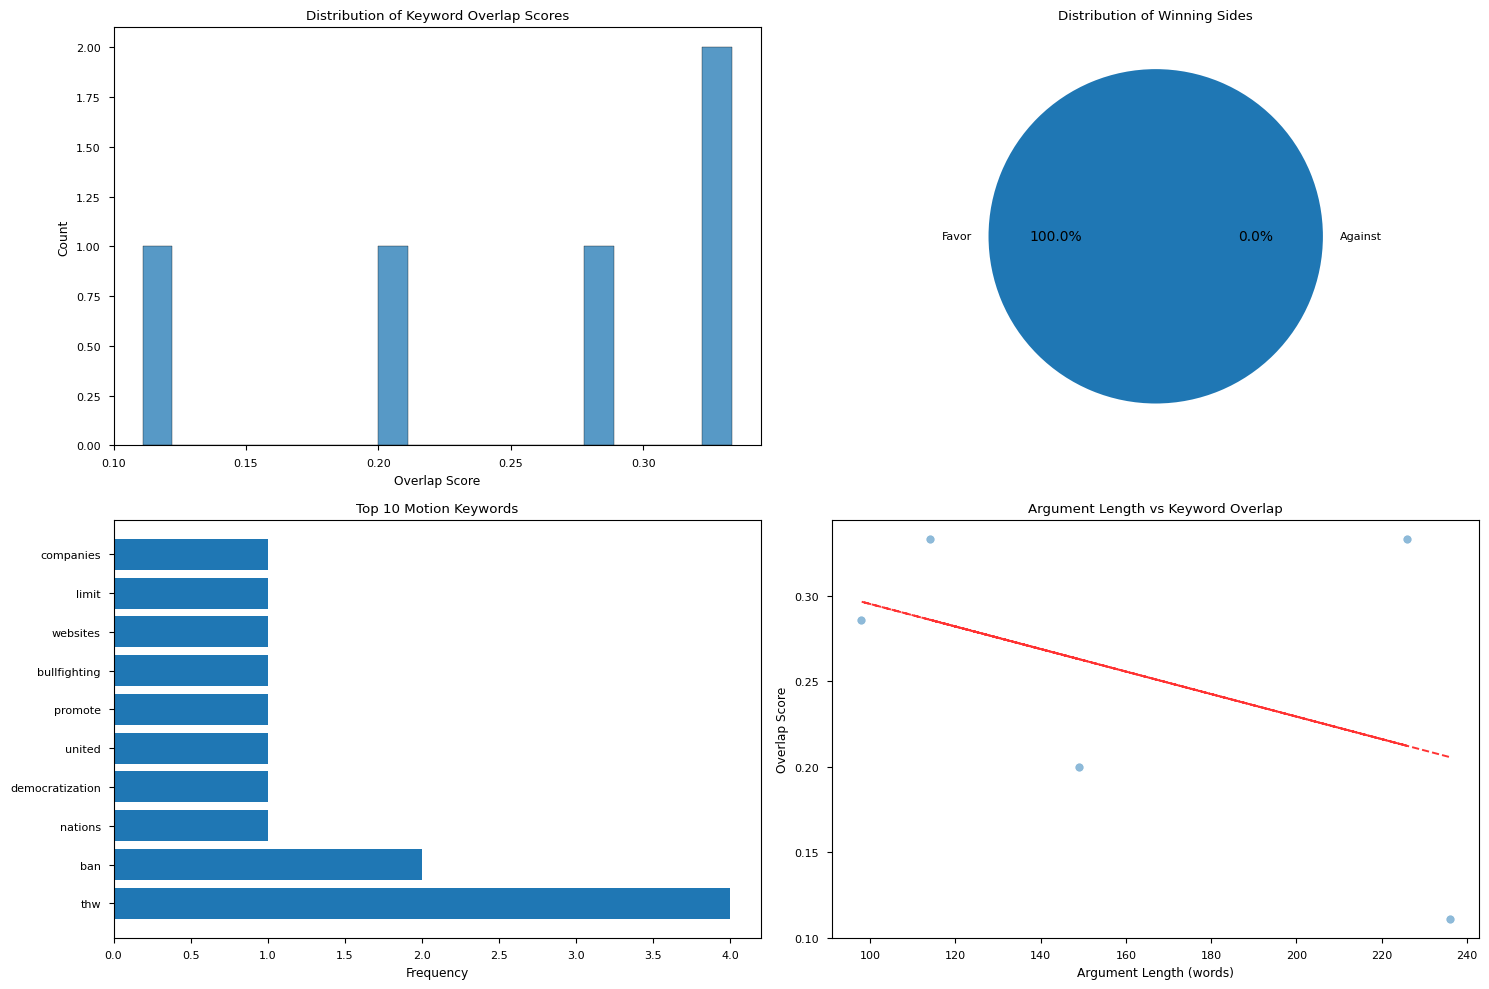

{'overlap_scores': [0.2,
  0.3333333333333333,
  0.3333333333333333,
  0.2857142857142857,
  0.1111111111111111],
 'word_frequencies': {'motion': {'thw': 4,
   'ban': 2,
   'nations': 1,
   'democratization': 1,
   'united': 1,
   'promote': 1,
   'bullfighting': 1,
   'websites': 1,
   'limit': 1,
   'companies': 1,
   'replace': 1,
   'technology': 1,
   'workers': 1,
   'ability': 1,
   'thbt': 1,
   'presents': 1,
   'handmade': 1,
   'get': 1,
   'girlfriend': 1,
   'gexpensive': 1},
  'winning_args': {'un': 1,
   'nations': 1,
   'would': 1,
   'representative': 1,
   'security': 1,
   'bullfighting': 1,
   'ethical': 1,
   'practice': 1,
   'health': 1,
   'medical': 1,
   'websites': 1,
   'technological': 1,
   'economic': 1,
   'era': 1,
   'companies': 1,
   'job': 1,
   'workers': 1,
   'dominated': 1,
   'items': 1,
   'love': 1}},
 'winning_sides': {'favor': 5, 'against': 0},
 'length_correlations': [(149, 0.2),
  (114, 0.3333333333333333),
  (226, 0.3333333333333333),
  

In [27]:
df_starchat = df[(df["winner"] != "HuggingFaceH4/starchat2-15b-v0.1") & ((df["favor_model"] == "HuggingFaceH4/starchat2-15b-v0.1") | (df["against_model"] == "HuggingFaceH4/starchat2-15b-v0.1"))]
compare_winning_arg_w_motion(df_starchat)